In [214]:
from typing import List, Optional, NamedTuple, Literal

import os
import pathlib
import math
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import sc_utils
import anndata as ad
import seaborn as sns
import Rbeast as rb
import sklearn.cluster
import sklearn.metrics

In [2]:
mpl.rcParams["figure.figsize"] = (10, 8)

In [3]:
pd.options.display.max_rows = 300

In [4]:
%config InlineBackend.figure_format = "retina"

In [5]:
FONT_DIR = '/projects/b1038/Pulmonary/nmarkov/fonts'
for f in os.listdir(FONT_DIR):
    if f.endswith('.ttf'):
        mpl.font_manager.fontManager.addfont(f'{FONT_DIR}/{f}')

In [6]:
mpl.rcParams["font.family"] = "Arial"
mpl.rcParams["pdf.fonttype"] = 42
# plt.rcParams['figure.constrained_layout.use'] = False
# mpl.rcParams['mathtext.default'] = 'regular'

In [7]:
ds = sc.read_h5ad("../../data/31_bal-object/03_bal-object/03_bal-object.h5ad")

In [8]:
ds.obs.cell_type = ds.obs.cell_type.astype(str).replace({
    'MoAM-3 mature': 'MoAM-2',
    'MoAM-4 profibrotic': 'MoAM-3 profibrotic',
    'gd/NKT cells': 'NK + γδT cells',
    'Perivascular macrophages': 'Interstitial macrophages',
}).astype('category')

In [9]:
ds.obs.Status = pd.Categorical(ds.obs.Status.astype(str).replace({
    'control': 'Control',
    'SSc': 'SSc-ILD'
}), categories=['Control', 'SSc-ILD'])

In [10]:
rng = np.random.default_rng(seed=101)
ds.uns['cell_type_colors'] = list(rng.permutation(
    ds.uns['cell_type_colors']
))

In [11]:
def get_color_annotations(df, mapping):
    result = []
    for column, palette in mapping.items():
        values = df[column].unique()
        if pd.api.types.is_categorical_dtype(df[column]):
            values = df[column].cat.categories
        if pd.api.types.is_numeric_dtype(df[column]):
            values = (df[column] - df[column].min()) / (df[column].max() - df[column].min())
            if not isinstance(palette, mpl.colors.Colormap):
                palette = sns.color_palette(palette, as_cmap=True)
            colors = palette(values)
            colors = [mpl.colors.to_hex(color) for color in colors]
            colors = pd.Series(colors, index=values.index, name=column)
        else:
            lut = dict(zip(values, sns.color_palette(palette, n_colors=values.size).as_hex()))
            colors = df[column].map(lut)
        result.append(colors)
    return pd.concat(result, axis=1)

# Transcription factor analysis of Myeloid cells in SSc BAL object

One of the important questions for our SSc BAL object is the relationship between different Macrophage subsets:
1. Do Monocytes give rise to TRAM?
2. Do Monocytes give rise to Profibrotic MoAM?
3. How are Profibrotic MoAM related to Perivascular macrophages?
4. Do Monocytes give rise to Perivascular macrophages?
5. Is Monocyte to Mature MoAM differentiation different from Monocyte to Profibrotic MoAM?

Here we want to use a list of known Transcript factors (TFs) to analyze these relationships, as they are known to regulate transcription and differentiation.

Below we obtain a list of human TFs and restrtict it to the expressed TFs in our dataset.

Here we limit ourselves to 4 cell types: Monocytes, MoAM, TRAM and Perivascular macrophages.

We exclude DCs and Proliferating macrophages, the former because they are from a different lineage, the latter because proliferation is a separate process involving many TFs, but we're not interested in it right now.

List of human transcription factros from http://humantfs.ccbr.utoronto.ca/index.php

In [14]:
TFS = pd.read_csv("TF_names_v_1.01.txt", header=None).iloc[:, 0]

In [15]:
TFS.size

1639

In [16]:
TFS.isin(ds.raw.var_names).sum()

1455

In [17]:
ds = ds[ds.obs.Chemistry.eq("10x 3' V3")].copy()

# 1. Check TF distribution in marker genes for our clusters

First, we would like to check which TFs are among the marker genes from our cell types and subtypes.

Marker genes were computed after clustering using standard scanpy procedure.

In [18]:
markers = pd.read_csv('../../data/31_bal-object/03_bal-object/03_bal-object-markers.csv', index_col=0)

In [19]:
markers.cluster = markers.cluster.replace({
    'MoAM-3 mature': 'MoAM-2',
    'MoAM-4 profibrotic': 'MoAM-3 profibrotic',
    'gd/NKT cells': 'NK + γδT cells',
    'Perivascular macrophages': 'Interstitial macrophages',
})

### And in DEGs

In [20]:
def get_cell_type_from_slug(slug: str, ds: sc.AnnData) -> str:
    OLD_SLUGS = {
        'MoAM-3_mature': 'MoAM-2',
        'MoAM-4_profibrotic': 'MoAM-3_profibrotic',
        'gd_NKT_cells': 'NK_+_γδT_cells',
        'Perivascular_macrophages': 'Interstitial_macrophages',
    }
    slug = OLD_SLUGS.get(slug, slug)
    for cell_type in ds.obs.cell_type.unique():
        cell_type_slug = cell_type.replace(" ", "_").replace("/", "_")
        if slug == cell_type_slug:
            return cell_type
    raise ValueError(f"Cannot find cluster for {slug}")

In [21]:
DATA = pathlib.Path('../../data/31_bal-object/')

In [22]:
DATA_DIR = DATA / 'pseudobulk-gsva'

In [23]:
DEG_DIR = DATA / '11_pseudobulk-v3'

In [24]:
MODEL = 'degs-status-sex'

def load_cell_type_info(folder, data_folder):
    name = folder.name
    degs = pd.read_csv(folder / MODEL / 'degs.csv', index_col=0)
    degs_filt = pd.read_csv(folder / MODEL / 'degs-filt.csv', index_col=0)
    expr = pd.read_table(data_folder / 'data' / f'{name}.txt', index_col=0)
    gene_cells = pd.read_table(data_folder / 'data' / f'{name}-n_cells.txt', index_col=0)
    meta = pd.read_csv(folder / 'meta.csv', index_col=0)

    go_ctrl = folder / MODEL / 'go-control.csv'
    if go_ctrl.exists():
        go_ctrl = pd.read_csv(go_ctrl, index_col=0)
    else:
        go_ctrl = None

    go_ssc = folder / MODEL / 'go-ssc.csv'
    if go_ssc.exists():
        go_ssc = pd.read_csv(go_ssc, index_col=0)
    else:
        go_ssc = None

    # ensure we operate on filtered samples
    gene_cells = gene_cells.loc[:, meta["External Sample ID"]]
    gene_cells = gene_cells.loc[gene_cells.sum(axis=1) > 0, :]

    return {
        'degs': degs,
        'filtered_degs': degs_filt,
        'meta': meta,
        'gene_cells': gene_cells,
        'expr': expr,
        'go_control': go_ctrl,
        'go_ssc': go_ssc,
    }


def process_cell_type(folder, data_folder, adata):
    info = {}

    clust = get_cell_type_from_slug(folder.name, adata)
    info.update(load_cell_type_info(folder, data_folder))

    return info

In [25]:
deg_data = {}

for folder in sorted(DEG_DIR.iterdir()):
    if not folder.is_dir():
        continue
    if not (folder / MODEL).exists():
        continue
    if folder.name == 'global':
        continue
    deg_data[folder.name] = process_cell_type(folder, DATA_DIR / folder.name, ds)

# 2. Myeloid object excluding DCs and Proliferating macrophages

Let's exclude DCs

In [26]:
myeloid = ds[ds.obs.cell_type.str.contains("TRAM|MoAM|macrophage|Mono", regex=True)]

In [27]:
myeloid = myeloid[myeloid.obs.cell_type.ne("Proliferating macrophages")].copy()

In [28]:
myeloid = myeloid.raw.to_adata()

In [29]:
myeloid = myeloid[:, myeloid.var_names.isin(TFS)]

Let's check TF expression across our Myeloid subset of the data

In [30]:
gene_n_non_zeros = (myeloid.X != 0).sum(axis=0)

In [31]:
gene_n_non_zeros = gene_n_non_zeros.A1

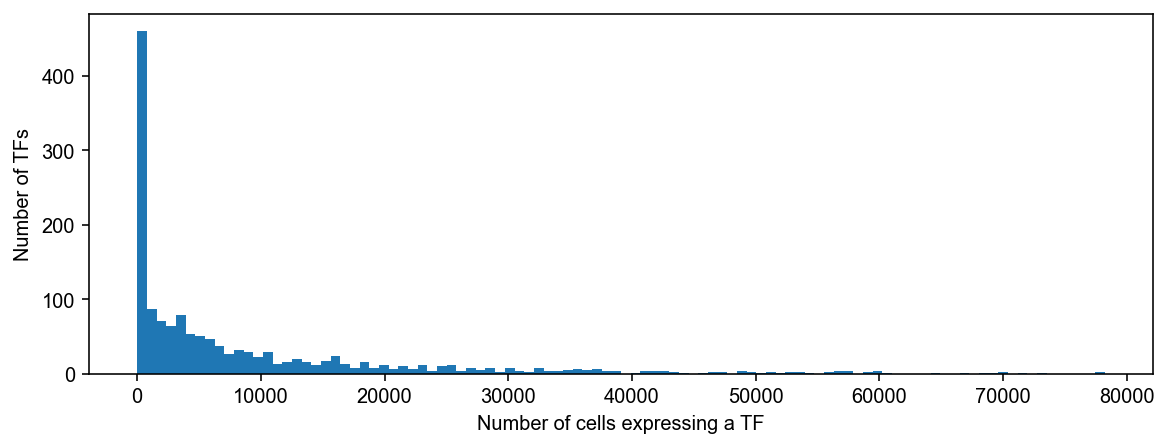

In [32]:
fig, ax = plt.subplots(figsize=(8, 3), constrained_layout=True)
ax.set_xlabel('Number of cells expressing a TF')
ax.set_ylabel('Number of TFs')
ax.hist(gene_n_non_zeros, bins=100);

In [33]:
(gene_n_non_zeros < 100).sum()

345

Let's exclude TFs expressed in less than 100 cells (345 TFs total)

In [34]:
myeloid = myeloid[:, gene_n_non_zeros >= 100].copy()

## 2.1 TF dotplot

Let's select all TFs which were detected as markers for one or more Myeloid clusters.

Then, let's plot a dot plot with them

In [35]:
moam_tfs = markers.loc[
    markers.gene.isin(TFS) & markers.cluster.isin(myeloid.obs.cell_type.unique())
].gene.unique()

In [36]:
moam_tfs.size

39

In [37]:
for k, v in deg_data.items():
    try:
        cell_type = get_cell_type_from_slug(k, myeloid)
    except:
        continue
    degs = v['filtered_degs'].index[
        v['filtered_degs'].sign.notna()
        & v['filtered_degs'].log2FoldChange.abs().gt(1)
    ]
    moam_tfs = np.union1d(np.intersect1d(degs, TFS), moam_tfs)

In [38]:
moam_tfs.size

50

In [39]:
myeloid.obs.cell_type = myeloid.obs.cell_type.cat.reorder_categories([
    'Monocytes', 'MoAM-1', 'MoAM-2', 'MoAM-3 profibrotic',
    'TRAM-1', 'TRAM-2', 'TRAM-3', 'TRAM-4', 'TRAM-5 MT1G', 'TRAM-6 activated',
    'Interstitial macrophages'
])

In [40]:
myeloid.obs.Study = myeloid.obs.Study.cat.reorder_categories(['Duke', 'this'])

In [41]:
sc.tl.dendrogram(myeloid, groupby='cell_type')

         Falling back to preprocessing with `sc.pp.pca` and default params.


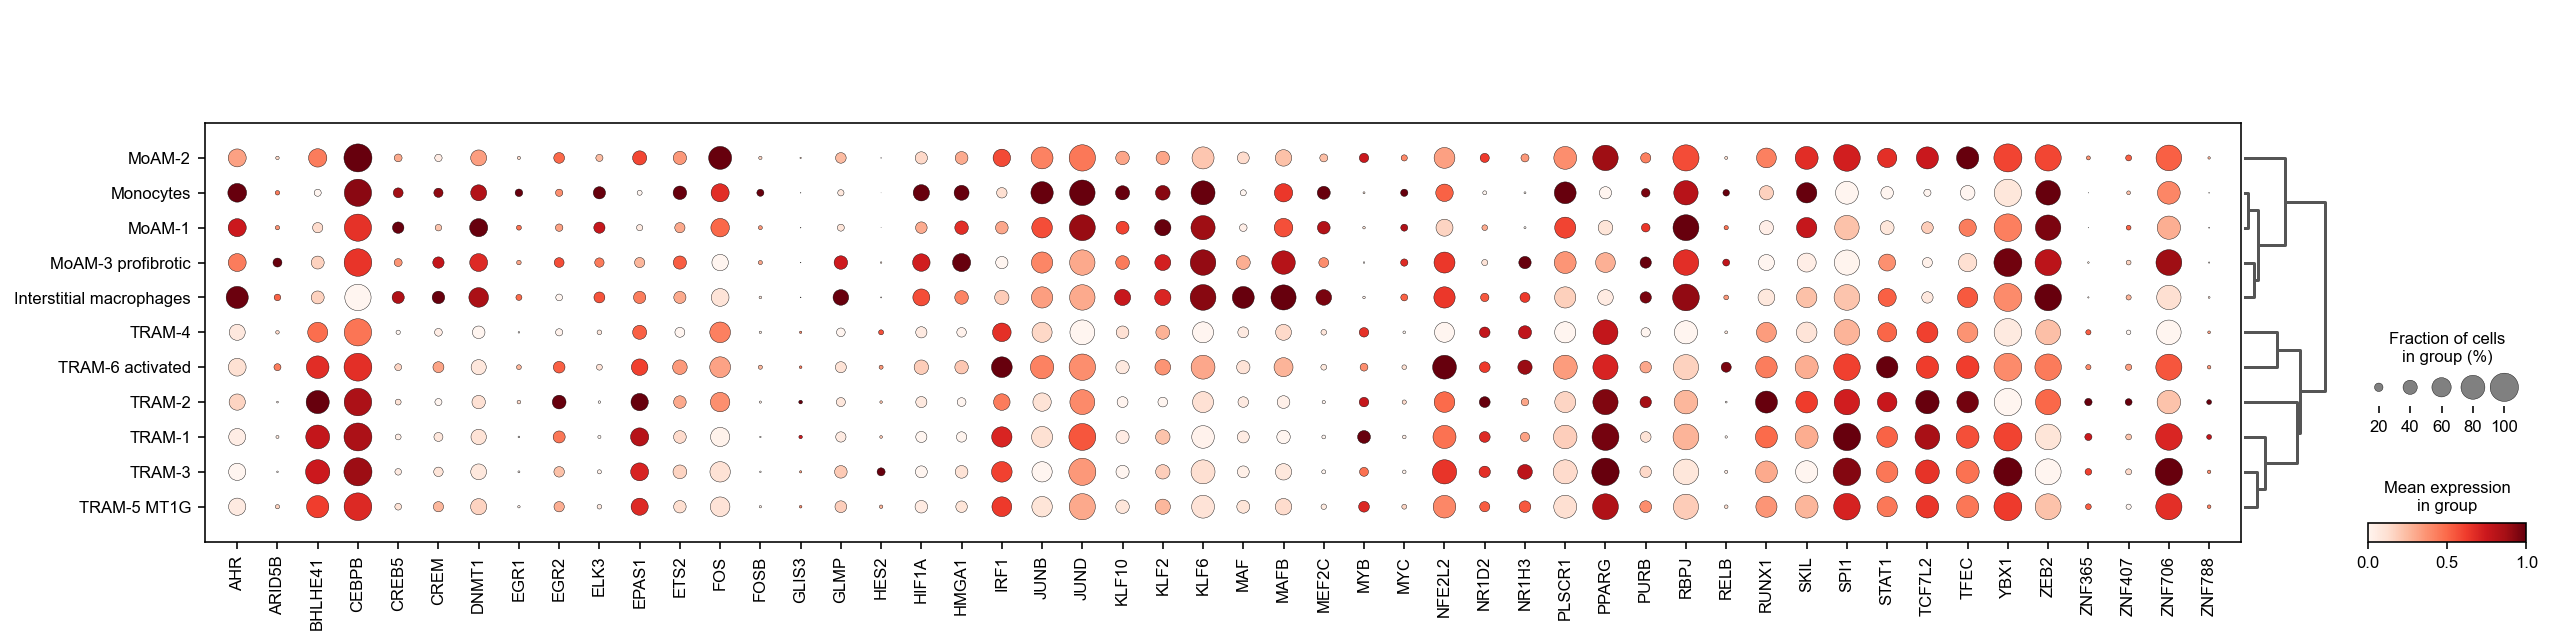

In [42]:
cg = sc.pl.dotplot(
    myeloid,
    moam_tfs,
    groupby='cell_type',
    standard_scale='var',
    dendrogram=True,
    show=False
)
cg['mainplot_ax'].figure.savefig('10b_plots/02_tf_dotplot_dend.pdf')

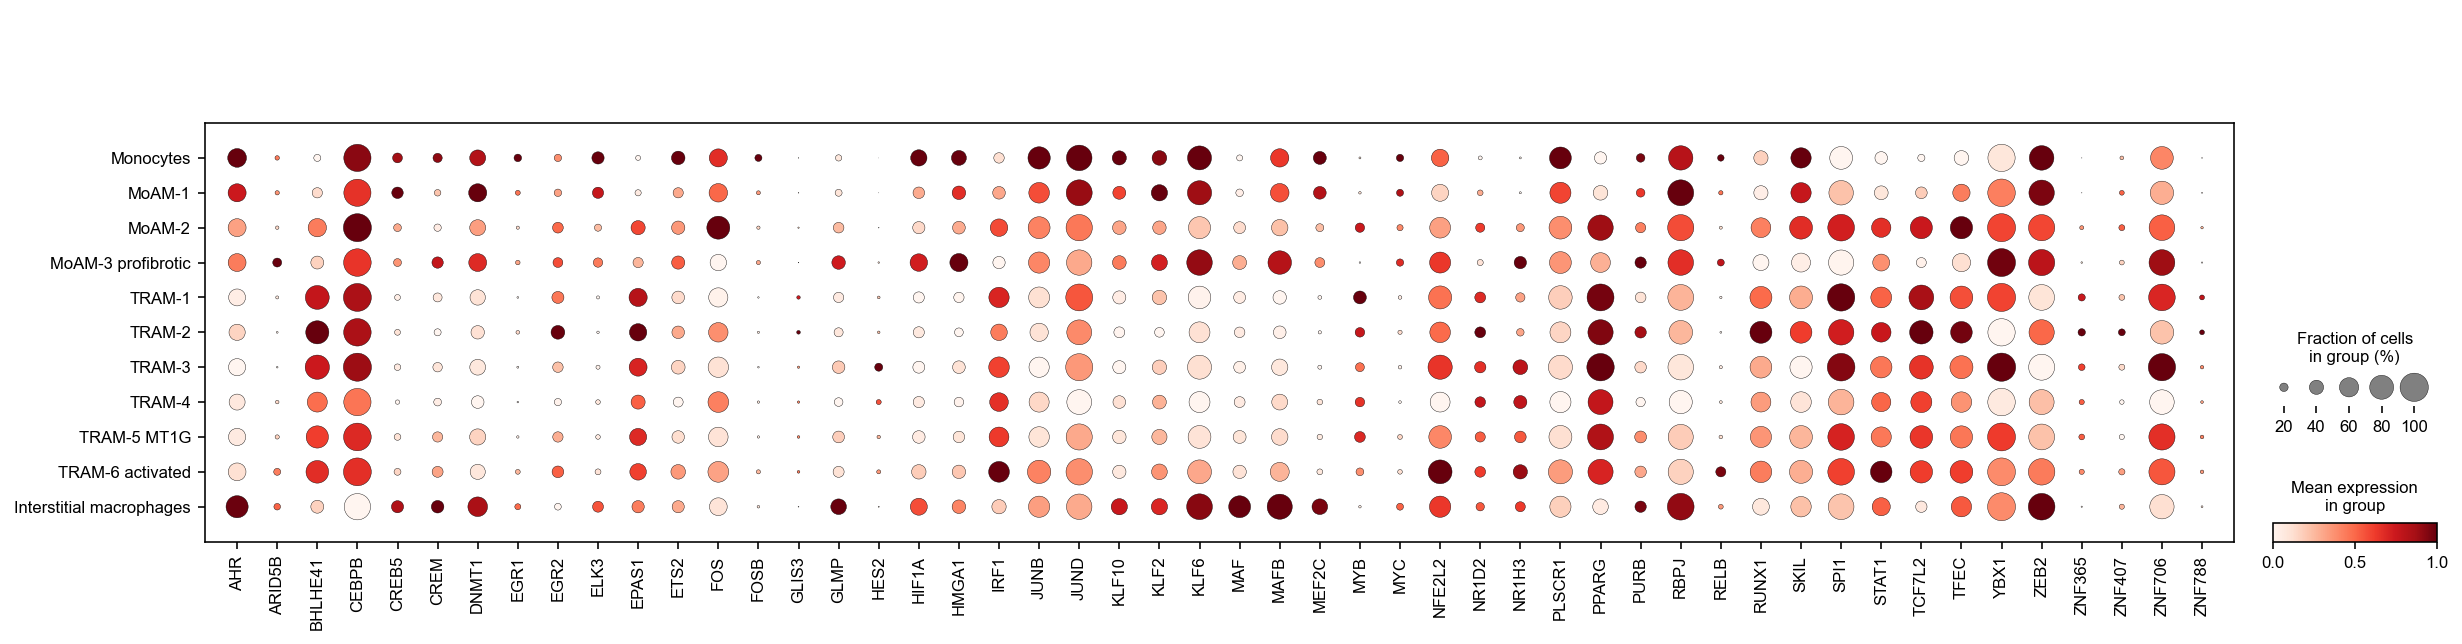

In [43]:
cg = sc.pl.dotplot(
    myeloid,
    moam_tfs,
    groupby='cell_type',
    standard_scale='var',
    show=False
)
cg['mainplot_ax'].figure.savefig('10b_plots/02_tf_dotplot.pdf')

In [44]:
myeloid.obs['cell_type_status'] = (
    myeloid.obs.cell_type.astype(str)
    + ', '
    + myeloid.obs.Status.astype(str)
)

In [45]:
order = []
for ct in myeloid.obs.cell_type.cat.categories:
    for st in myeloid.obs.Status.cat.categories:
        order.append(f'{ct}, {st}')

In [46]:
myeloid.obs.cell_type_status = pd.Categorical(myeloid.obs.cell_type_status, categories=order)

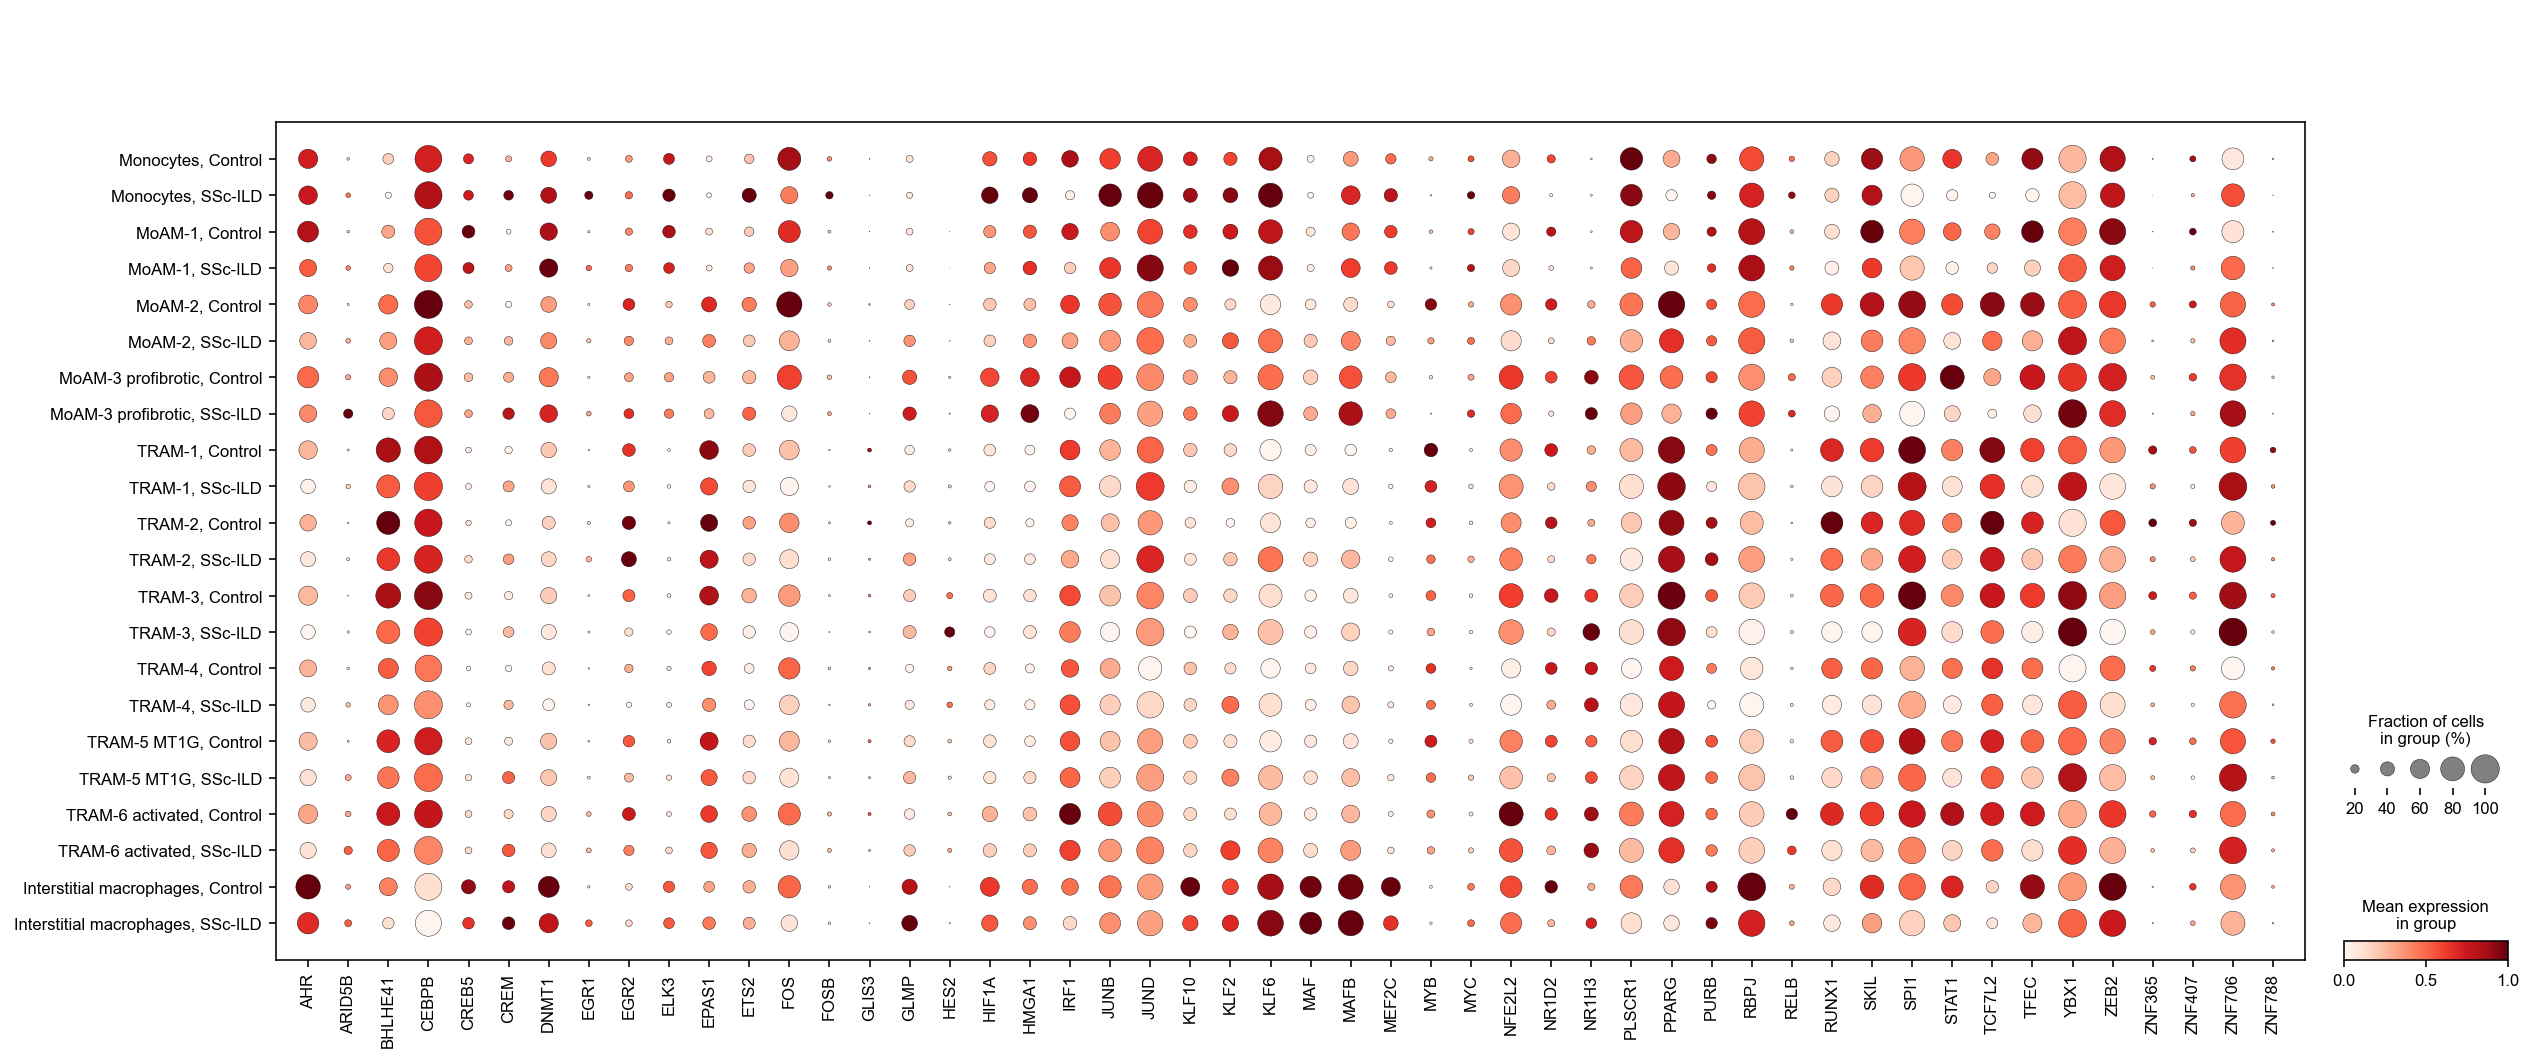

In [47]:
cg = sc.pl.dotplot(
    myeloid,
    moam_tfs,
    groupby='cell_type_status',
    standard_scale='var',
    show=False
)
cg['mainplot_ax'].figure.savefig('10b_plots/02_tf_dotplot_split.pdf')

## 2.2 TF heatmap

Let's plot all cells TF expression as heatmap

In [48]:
tf_expr = myeloid[:, moam_tfs].X.todense()

In [49]:
tf_expr = pd.DataFrame(tf_expr, index=myeloid.obs_names, columns=moam_tfs)

In [50]:
tf_expr = tf_expr.loc[tf_expr.sum(axis=1) > 0]

In [51]:
df_color = get_color_annotations(myeloid.obs[['cell_type', 'Study', 'Status']], {
    'cell_type': 'tab20',
    'Status': ['royalblue', 'firebrick'],
    'Study': ['white', 'gray']
})

In [52]:
tf_expr['Study'] = myeloid.obs.Study[tf_expr.index]
tf_expr['Status'] = myeloid.obs.Status[tf_expr.index]
tf_expr['cell_type'] = myeloid.obs.cell_type[tf_expr.index]
tf_expr.sort_values(['cell_type', 'Status', 'Study'], inplace=True)
tf_expr.drop(columns=['cell_type', 'Status', 'Study'], inplace=True)

Instead of normalizing for visualization to 0–1 range using `min` and `max`, we use 99th percentile instead of `max`, otherwise most of the plot is black.

For visualization, we clip values above 99th percentile to the 99th percentile

In [53]:
tf_expr_viz = (tf_expr - tf_expr.min(axis=0)) / (tf_expr.quantile(q=0.99, axis=0) - tf_expr.min(axis=0))

In [54]:
tf_expr_viz.fillna(0, inplace=True)

In [55]:
tf_expr_viz[tf_expr_viz.eq(np.Inf)] = 1

/projects/b1038/Pulmonary/nmarkov/ssc-v2/code/venv/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


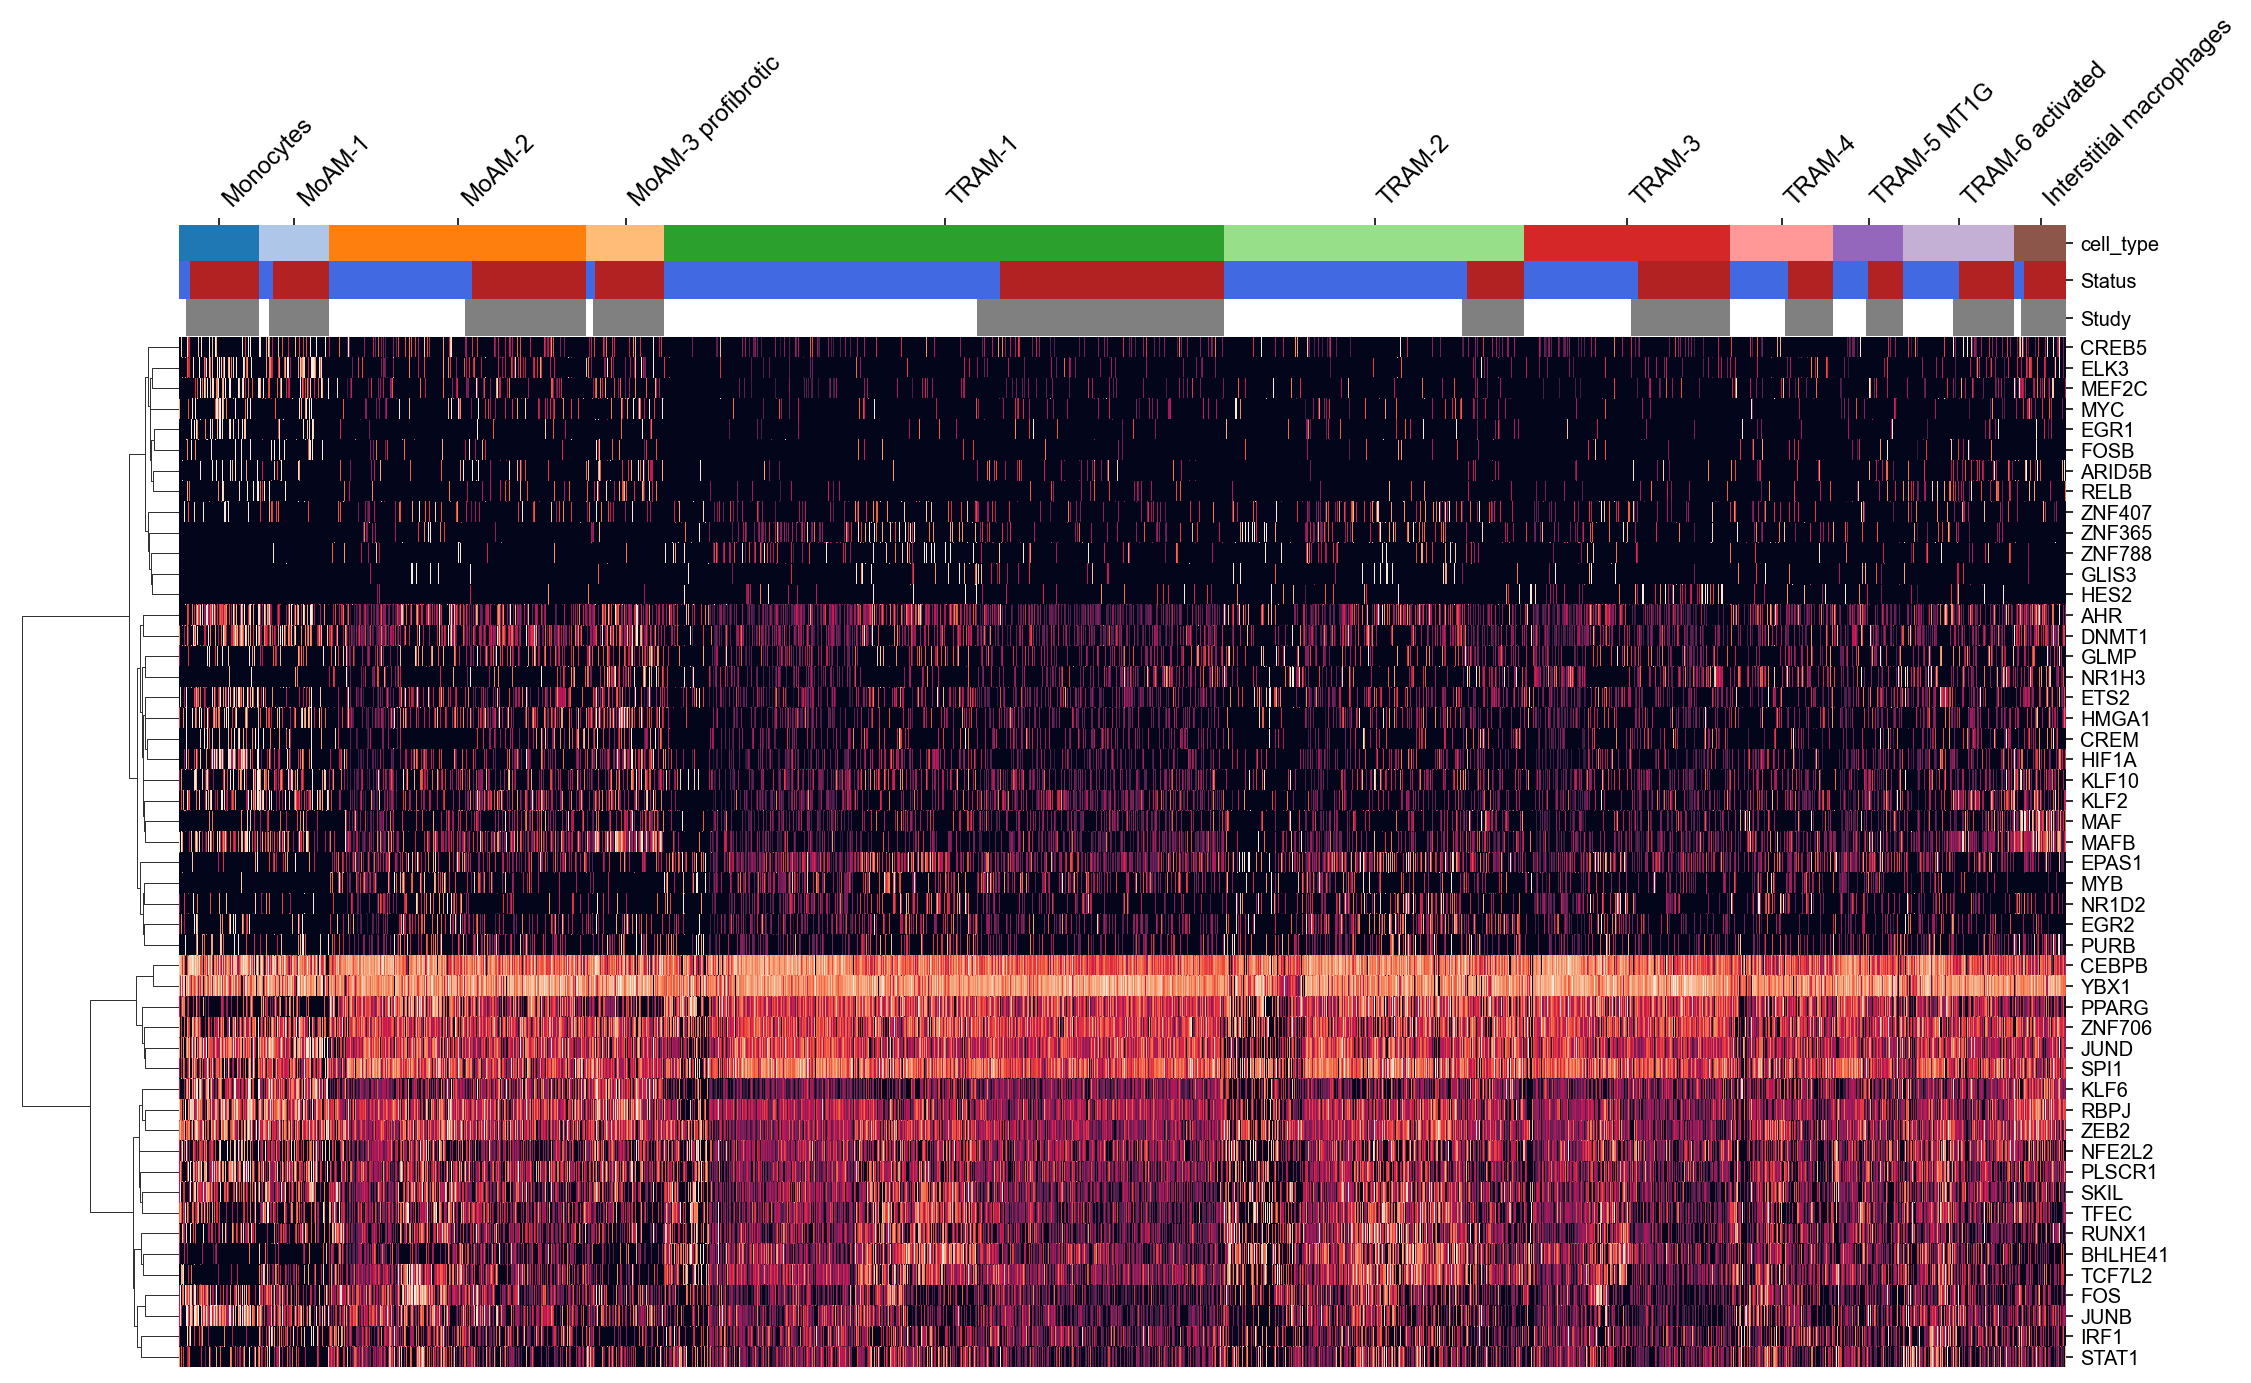

In [56]:
cg = sns.clustermap(
    tf_expr_viz.T,
    col_cluster=False,
#     standard_scale=0,
    method='ward',
    xticklabels=[],
    yticklabels=tf_expr.columns,
    col_colors=df_color,
    figsize=(16, 10),
    cbar_pos=None,
    dendrogram_ratio=0.08,
    vmax=1
)
xticklabels, xticks = zip(
    *(myeloid.obs.sort_values('cell_type').cell_type.reset_index().reset_index()
        .groupby('cell_type').level_0.mean().iteritems())
)
cg.ax_col_colors.set_xticks(xticks)
cg.ax_col_colors.set_xticklabels(xticklabels, size=12, rotation=45, ha="left")
cg.ax_col_colors.tick_params(bottom=False, labelbottom=False, top=True, labeltop=True)
cg.ax_heatmap.collections[0].set_rasterized(True)
cg.ax_col_colors.collections[0].set_rasterized(True)
cg.ax_heatmap.figure.subplots_adjust(top=0.88, right=0.9)
cg.ax_heatmap.figure.savefig('10b_plots/01_tf_heatmap.pdf', dpi=300)

## 2.3 Two trajectories

From TF expression above, I propose that in our data there are 2 trajectories:
1. Monocytes → MoAM-1 → MoAM-3 mature → TRAM-1
2. Monocytes → MoAM-1 (?) → MoAM-4 profibrotic

I will plot heatmaps for that

In [57]:
myeloid_tfs = myeloid[:, moam_tfs].copy()

In [58]:
sc.pp.neighbors(myeloid_tfs, use_rep='X_scVI')

In [59]:
sc.tl.diffmap(myeloid_tfs)

In [60]:
iroot_idx = myeloid_tfs.X[
    myeloid_tfs.obs.cell_type.eq('Monocytes')
][:, myeloid_tfs.var_names == 'HIF1A'].argmax()

In [61]:
myeloid_tfs.uns["iroot"] = np.flatnonzero(myeloid_tfs.obs.cell_type.eq("Monocytes"))[iroot_idx]

In [62]:
sc.tl.dpt(myeloid_tfs)

In [63]:
myeloid_tfs.X = myeloid_tfs.X.todense()

In [64]:
sc.tl.paga(myeloid_tfs, groups='cell_type')

Remove 50% of TRAM-1 randomly for visualization

In [65]:
idx = myeloid_tfs.obs.cell_type.eq('TRAM-1')
rng = np.random.default_rng(1066)
to_remove = rng.choice(np.flatnonzero(idx), size=math.floor(idx.sum() * 0.5), replace=False)

In [66]:
to_remove = myeloid_tfs.obs_names[to_remove]

### Trajectory 1: Monocytes → MoAM-1 → MoAM-3 mature → TRAM-1

In [71]:
ORDER = [
    'CEBPB', 'SPI1', 'ZNF706', 'YBX1', 'PURB', 'GLMP',
    'JUND', 'JUNB', 'ZEB2', 'SKIL', 'PLSCR1', 'NFE2L2', 'KLF6', 'RBPJ',
    'HMGA1', 'AHR', 'KLF10', 'MAFB', 'KLF2', 'DNMT1', 'HIF1A', 'ETS2', 'CREM', 'ARID5B', 'RELB', 'ELK3', 'EGR1',
    'FOSB', 'MEF2C', 'CREB5', 'MYC',
    'EGR2', 'RUNX1', 'FOS', 'STAT1', 'IRF1', 'PPARG', 'TFEC', 'TCF7L2', 'NR1D2', 'NR1H3', 'EPAS1', 'BHLHE41', 'ZNF407',
    'MAF', 'MYB', 'HES2', 'GLIS3', 'ZNF365', 'ZNF788'
]

In [72]:
pd.Series(ORDER)[pd.Series(ORDER).duplicated()]

Series([], dtype: object)

In [73]:
len(ORDER)

50

In [74]:
moam_tfs[~np.isin(moam_tfs, ORDER)]

array([], dtype=object)

/projects/b1038/Pulmonary/nmarkov/ssc-v2/code/venv/lib/python3.9/site-packages/scanpy/plotting/_tools/paga.py:1188: UserWarning: FixedFormatter should only be used together with FixedLocator
  groups_axis.set_yticklabels(['', xlabel, ''], fontsize=ytick_fontsize)
/projects/b1038/Pulmonary/nmarkov/ssc-v2/code/venv/lib/python3.9/site-packages/scanpy/plotting/_tools/paga.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  anno_axis.set_yticklabels(['', anno, ''], fontsize=ytick_fontsize)


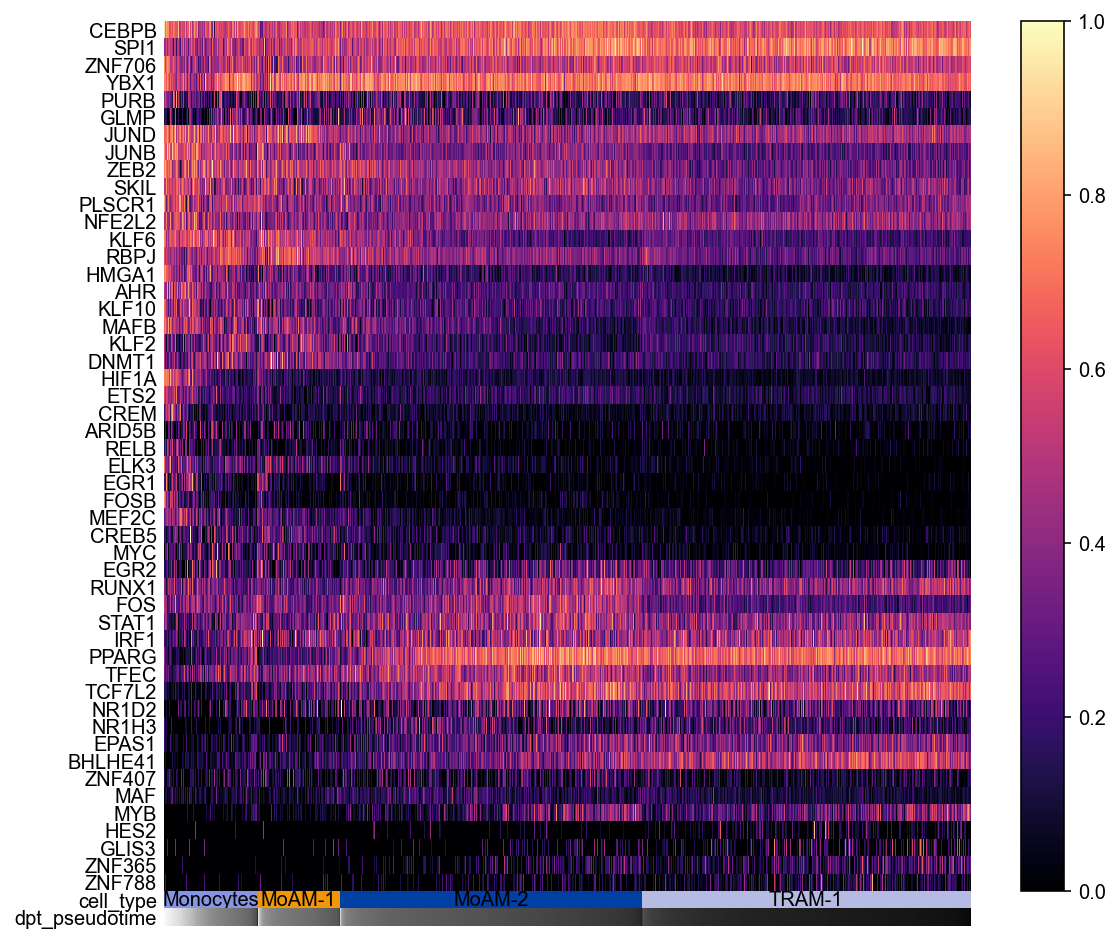

In [75]:
ax = sc.pl.paga_path(
    myeloid_tfs[~myeloid_tfs.obs_names.isin(to_remove)],
    nodes=['Monocytes', 'MoAM-1', 'MoAM-2', 'TRAM-1'],
    keys=ORDER,
    use_raw=False,
    n_avg=10,
    normalize_to_zero_one=True,
    show=False,
    color_map='magma'
)
ax.images[0].set_rasterized(True)
ax.figure.savefig('10b_plots/03_tf_trajectory1.pdf', dpi=300)

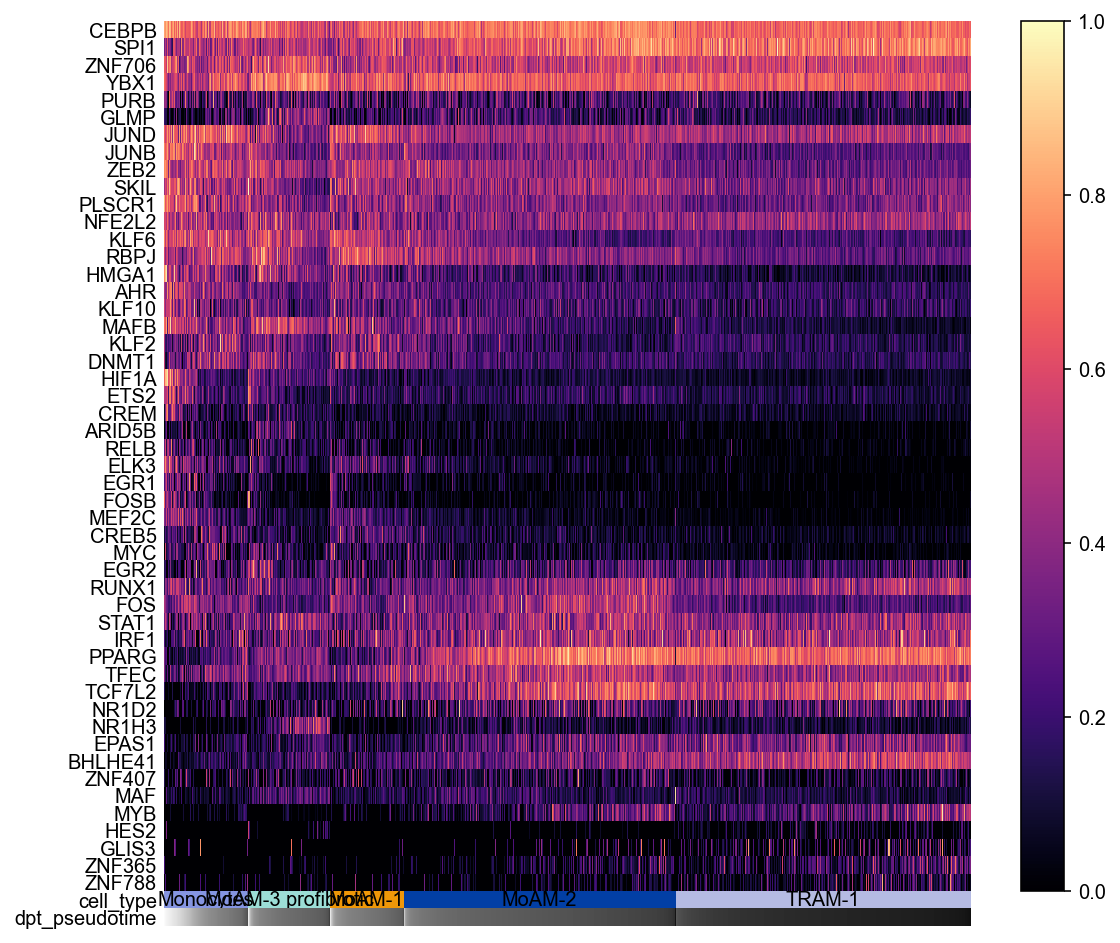

In [76]:
ax = sc.pl.paga_path(
    myeloid_tfs[~myeloid_tfs.obs_names.isin(to_remove)],
    nodes=['Monocytes', 'MoAM-3 profibrotic', 'MoAM-1', 'MoAM-2', 'TRAM-1'],
    keys=ORDER,
    use_raw=False,
    n_avg=10,
    normalize_to_zero_one=True,
    show=False,
    color_map='magma'
)
ax.images[0].set_rasterized(True)
# ax.figure.savefig('10b_plots/03_tf_trajectory1.pdf', dpi=300)

In [259]:
myeloid_tfs_viz = myeloid_tfs[~myeloid_tfs.obs_names.isin(to_remove)].copy()
myeloid_tfs_viz = myeloid_tfs_viz[myeloid_tfs_viz.obs.cell_type.isin([
    'Monocytes', 'MoAM-1', 'MoAM-2', 'MoAM-3 profibrotic', 'TRAM-1'
])].copy()
myeloid_tfs_viz.obs.cell_type = myeloid_tfs_viz.obs.cell_type.cat.reorder_categories([
    'Monocytes', 'MoAM-1', 'MoAM-3 profibrotic', 'MoAM-2', 'TRAM-1'
])

In [260]:
cell_order = myeloid_tfs_viz.obs.sort_values(['cell_type', 'dpt_pseudotime']).index

In [261]:
myeloid_tfs_viz = myeloid_tfs_viz[cell_order].copy()

In [262]:
myeloid_tfs_viz_df = pd.DataFrame(
    myeloid_tfs_viz.X,
    index=myeloid_tfs_viz.obs_names,
    columns=myeloid_tfs_viz.var_names
)

In [263]:
cell_type_colors = dict(zip(
    ds.obs.cell_type.cat.categories,
    ds.uns['cell_type_colors']
))

In [265]:
myeloid_tfs_viz_df_norm = (
    (myeloid_tfs_viz_df - myeloid_tfs_viz_df.min()) 
    / (myeloid_tfs_viz_df.max() - myeloid_tfs_viz_df.min())
)
myeloid_tfs_viz_df_mean = myeloid_tfs_viz_df_norm.groupby([
    # myeloid_tfs_viz.obs['External Sample ID'],
    myeloid_tfs_viz.obs.cell_type,
]).mean()
myeloid_tfs_viz_df_mean = (
    myeloid_tfs_viz_df_mean
    / myeloid_tfs_viz_df_mean.max()
)

In [266]:
result = []
for candidate in range(2, 11):
    clustering = sklearn.cluster.KMeans(n_clusters=candidate, n_init=1000, random_state=1067).fit(myeloid_tfs_viz_df_mean.T)
    metric = sklearn.metrics.silhouette_score(myeloid_tfs_viz_df_mean.T, clustering.labels_)
    result.append((candidate, metric, clustering.inertia_))

2

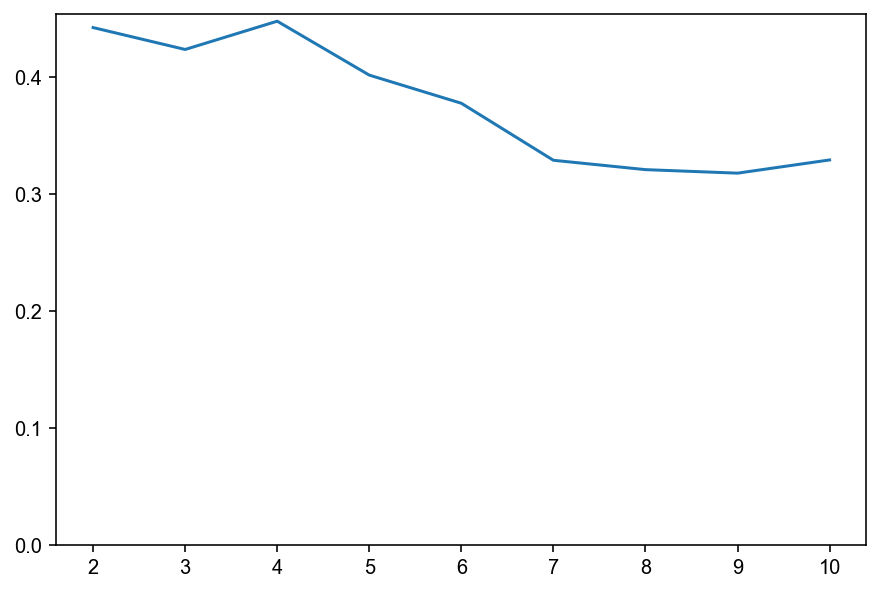

In [267]:
fig, ax = plt.subplots(figsize=(6, 4), constrained_layout=True)
ax.plot([x[0] for x in result], [x[1] for x in result])
# ax.plot([x[0] for x in result], [x[2] for x in result])
ax.set_ylim(0)
np.array([x[1] for x in result]).argmax()

In [268]:
clustering = sklearn.cluster.KMeans(n_clusters=4, n_init=1000, random_state=1067).fit(myeloid_tfs_viz_df_mean.T)

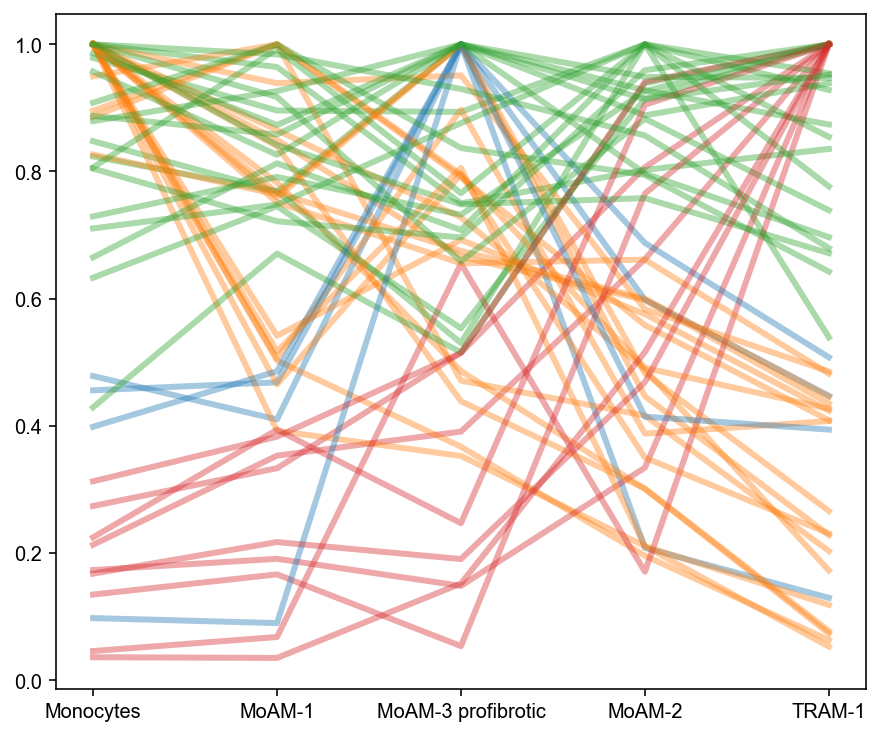

In [269]:
fig, ax = plt.subplots(figsize=(6, 5), constrained_layout=True)
for cluster, (_, r) in zip(clustering.labels_, myeloid_tfs_viz_df_mean.T.iterrows()):
# for cluster, (_, r) in zip(clustering.labels_, myeloid_tfs_viz_df_mean.T.iterrows()):
    ax.plot(r.index, r.values, color=mpl.cm.tab10(cluster), alpha=0.4, lw=3)

In [270]:
myeloid_tfs_viz_df_mean_t = myeloid_tfs_viz_df_mean.T.copy()
myeloid_tfs_viz_df_mean_t.columns = myeloid_tfs_viz_df_mean_t.columns.astype(str)
myeloid_tfs_viz_df_mean_t['cluster'] = clustering.labels_

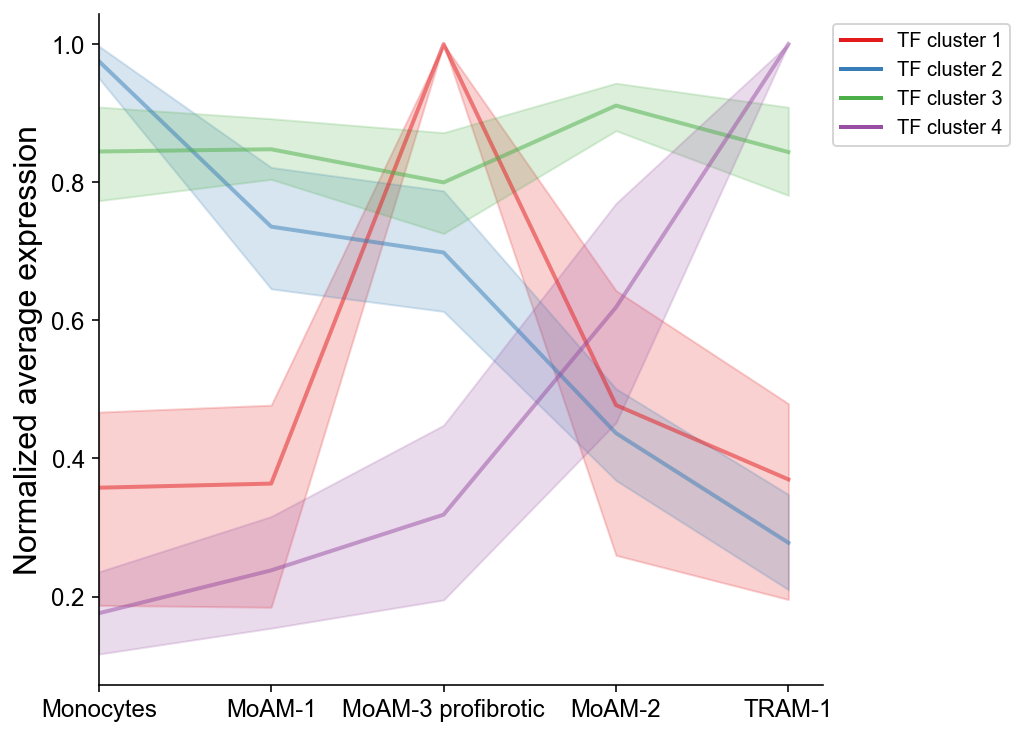

In [298]:
fig, ax = plt.subplots(figsize=(7, 5), constrained_layout=True)
for cluster in range(myeloid_tfs_viz_df_mean_t.cluster.max() + 1):
    plot_df = myeloid_tfs_viz_df_mean_t.loc[myeloid_tfs_viz_df_mean_t.cluster.eq(cluster)].iloc[:, :-1].T.reset_index().melt(
        id_vars='cell_type',
    )
    sns.lineplot(
        data=plot_df,
        x='cell_type',
        y='value',
        ax=ax,
        color=mpl.cm.Set1(cluster),
        alpha=0.5,
        label=f'TF cluster {cluster + 1}',
        lw=2
    )
ax.set_xlim(0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('')
ax.tick_params(labelsize=12)
ax.set_ylabel('Normalized average expression', size=16)
legend = ax.legend(
    loc='upper left',
    bbox_to_anchor=(1, 1)
)
for lh in legend.legendHandles: 
    lh.set_alpha(1)
fig.savefig('00_figures/Figure_4E_tf_clusters.pdf')

In [293]:
myeloid_tf_cluster = myeloid_tfs_viz_df_mean_t.copy()
myeloid_tf_cluster.cluster = pd.Categorical(myeloid_tf_cluster.cluster, categories=range(myeloid_tf_cluster.cluster.max() + 1))

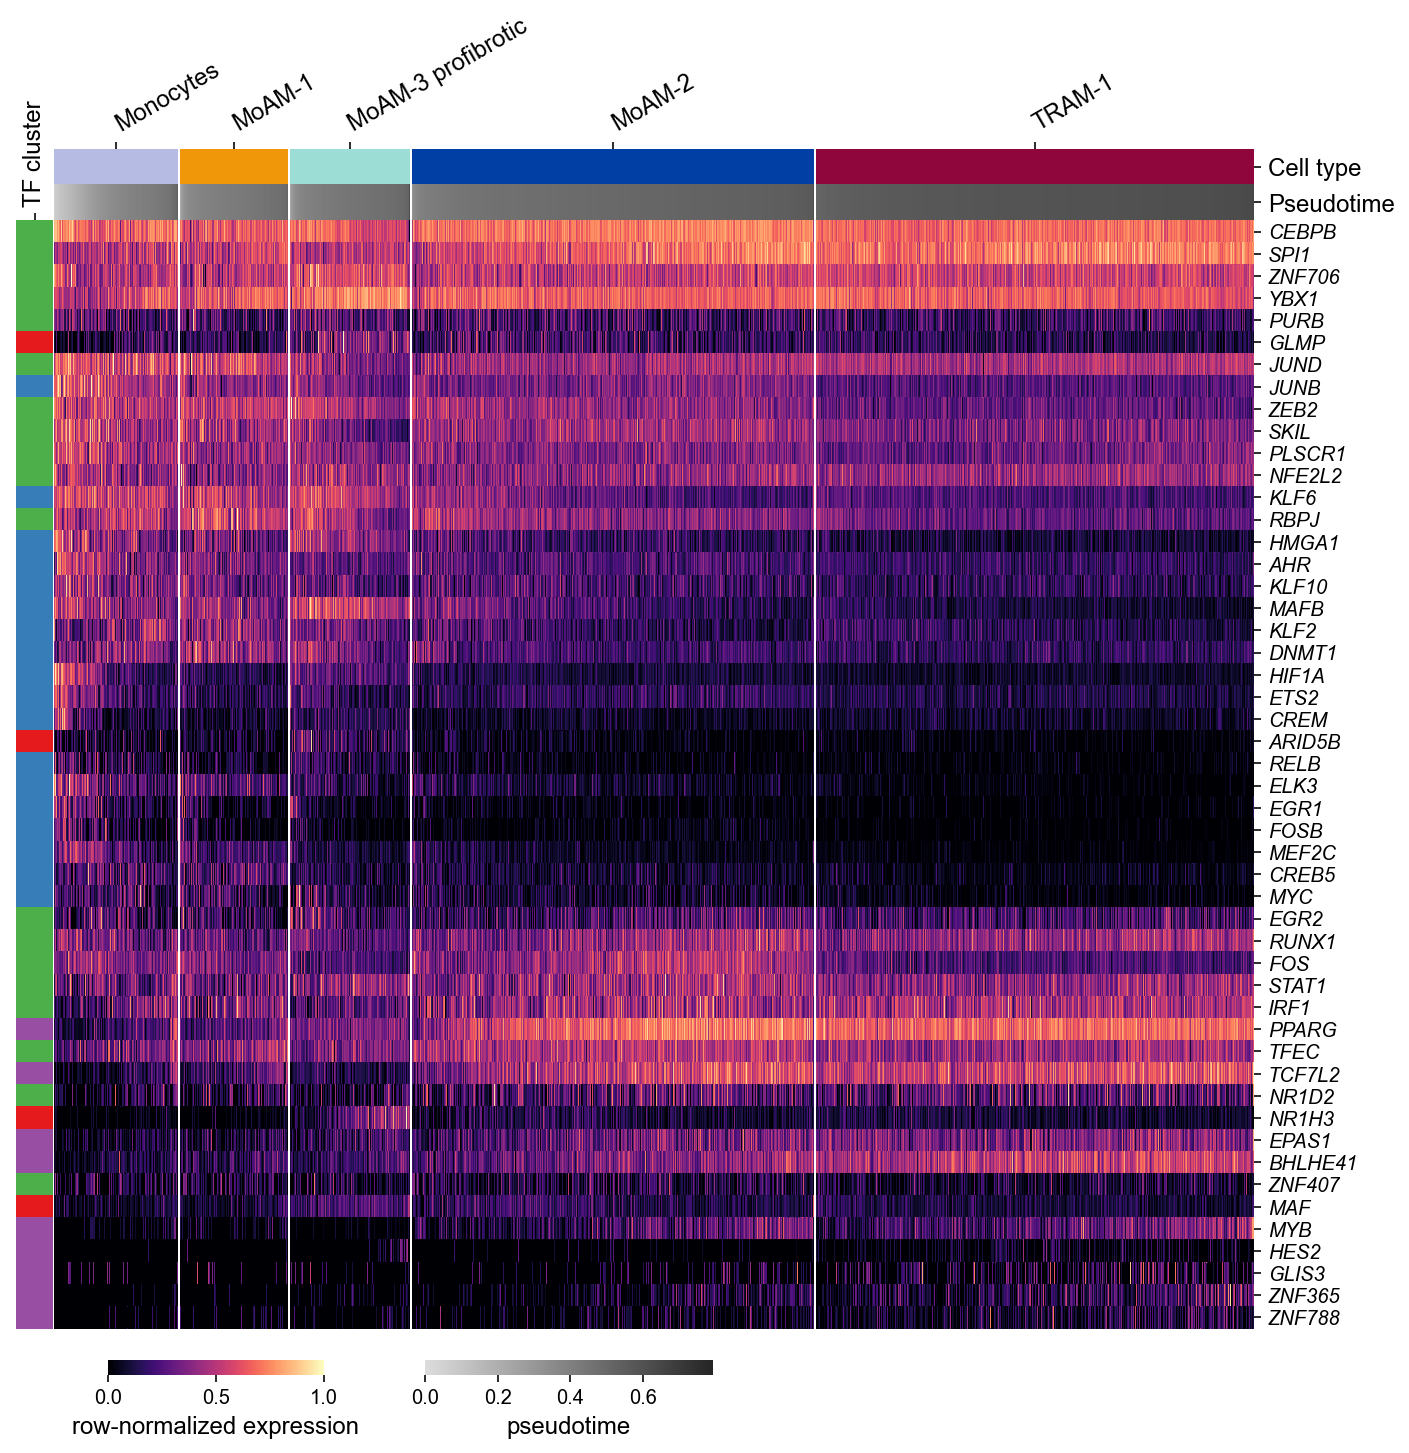

In [300]:
pseudotime_cmap = sns.dark_palette('#ddd', as_cmap=True, reverse=True)
cg = sns.clustermap(
    myeloid_tfs_viz_df.loc[:, ORDER].rolling(10).mean().dropna().T,
    cmap='magma',
    yticklabels=ORDER,
    xticklabels=False,
    standard_scale=0,
    row_cluster=False,
    col_cluster=False,
    col_colors=get_color_annotations(myeloid_tfs_viz.obs, {
        'cell_type': [cell_type_colors[x] for x in myeloid_tfs_viz.obs.cell_type.cat.categories],
        'dpt_pseudotime': pseudotime_cmap
    }),
    row_colors=get_color_annotations(myeloid_tf_cluster.loc[ORDER], {
        'cluster': 'Set1'
    }),
    dendrogram_ratio=0.001,
    cbar_kws=dict(
        label='row-normalized expression',
        orientation='horizontal'
    ),
)
cg.ax_col_colors.set_xticks(
    myeloid_tfs_viz.obs.reset_index(drop=True).reset_index().groupby('cell_type').index.mean()
)
cg.ax_col_colors.set_xticklabels(
    myeloid_tfs_viz.obs.cell_type.cat.categories,
    size=12
)
cg.ax_col_colors.set_yticklabels(['Cell type', 'Pseudotime'], size=12)
cg.ax_col_colors.tick_params(axis='x', bottom=False, top=True, labelbottom=False, labeltop=True, rotation=30)
cg.ax_row_colors.set_xticklabels(['TF cluster'], size=12)
cg.ax_row_colors.tick_params(bottom=False, top=True, labelbottom=False, labeltop=True, rotation=90)

trans = mpl.transforms.Affine2D().translate(-5, 0)
for t in cg.ax_col_colors.get_xticklabels():
    t.set_ha('left')
    t.set_transform(t.get_transform() + trans)

for ct in myeloid_tfs_viz.obs.cell_type.unique()[1:]:
    # draw vertical lines for each cell type
    meta = myeloid_tfs_viz.obs.reset_index(drop=True).reset_index()
    ct_loc = meta.index.get_loc(meta.index[meta.cell_type.eq(ct)][0])
    cg.ax_heatmap.axvline(ct_loc, color='w', lw=1)
    cg.ax_col_colors.axvline(ct_loc, color='w', lw=1)
cg.ax_cbar.set_xlabel(cg.ax_cbar.get_xlabel(), fontsize=12)
cg.ax_heatmap.set_yticklabels(cg.ax_heatmap.get_yticklabels(), fontstyle='italic')
cg.ax_heatmap.tick_params(labelsize=10)

pseudotime_leg_ax = cg.figure.add_axes((0.3, 0.048, 0.2, 0.01))
pseudotime_cbar = cg.figure.colorbar(
    mpl.cm.ScalarMappable(
        norm=mpl.colors.Normalize(
            vmin=myeloid_tfs_viz.obs.dpt_pseudotime.min(),
            vmax=myeloid_tfs_viz.obs.dpt_pseudotime.max()
        ),
        cmap=pseudotime_cmap
    ),
    cax=pseudotime_leg_ax,
    label='pseudotime',
    orientation='horizontal',
    drawedges=False,
)
pseudotime_leg_ax.set_xlabel(pseudotime_leg_ax.get_xlabel(), fontsize=12)

pseudotime_cbar.outline.set_linewidth(0)

cg.figure.subplots_adjust(bottom=0.08, top=0.9)

cg.ax_cbar.set_position((0.08, 0.048, 0.15, 0.01))
cg.ax_cbar.set_xlabel(cg.ax_cbar.get_xlabel(), fontsize=12)

cg.ax_col_colors.collections[0].set_rasterized(True)
cg.ax_row_colors.collections[0].set_rasterized(True)
cg.ax_heatmap.collections[0].set_rasterized(True)

cg.figure.savefig('00_figures/Figure_4D_tf_pseudotime.pdf', dpi=300)

In [272]:
myeloid_tfs_viz_df_mean_t.loc[myeloid_tfs_viz_df_mean_t.cluster.eq(0)]

cell_type  Monocytes    MoAM-1  MoAM-3 profibrotic    MoAM-2    TRAM-1  \
ARID5B      0.478311  0.410094                 1.0  0.208202  0.129543   
GLMP        0.455881  0.468466                 1.0  0.598420  0.447210   
MAF         0.398562  0.485874                 1.0  0.687672  0.507756   
NR1H3       0.097719  0.089870                 1.0  0.414438  0.394124   

cell_type  cluster  
ARID5B           0  
GLMP             0  
MAF              0  
NR1H3            0

In [273]:
myeloid_tfs_viz_df_mean_t.loc['PPARG']

cell_type
Monocytes             0.312844
MoAM-1                0.383034
MoAM-3 profibrotic    0.514602
MoAM-2                0.940859
TRAM-1                1.000000
cluster               3.000000
Name: PPARG, dtype: float64

In [258]:
myeloid_tfs_viz_df_mean_t.loc['MAFB']

cell_type
Monocytes             0.826833
MoAM-3 profibrotic    1.000000
MoAM-1                0.763976
MoAM-2                0.446460
TRAM-1                0.228317
cluster               1.000000
Name: MAFB, dtype: float64

## Old and experimental stuff below

In [93]:
df = sc.get.obs_df(myeloid_tfs, keys=['cell_type', 'dpt_pseudotime', 'PPARG'])

In [94]:
df = df.loc[df.cell_type.isin(['Monocytes', 'MoAM-1', 'MoAM-3 mature', 'TRAM-1'])]

In [95]:
df = df.sort_values(['cell_type', 'dpt_pseudotime'])

\Progress:100.0% done[==============================================================]


(<Figure size 720x576 with 5 Axes>,
 array([<AxesSubplot:xlabel='[]', ylabel='trend'>,
        <AxesSubplot:xlabel='[]', ylabel='Pr(tcp)'>,
        <AxesSubplot:xlabel='[]', ylabel='tOrder'>,
        <AxesSubplot:xlabel='[]', ylabel='slpsgn'>,
        <AxesSubplot:xlabel='time', ylabel='error'>], dtype=object))

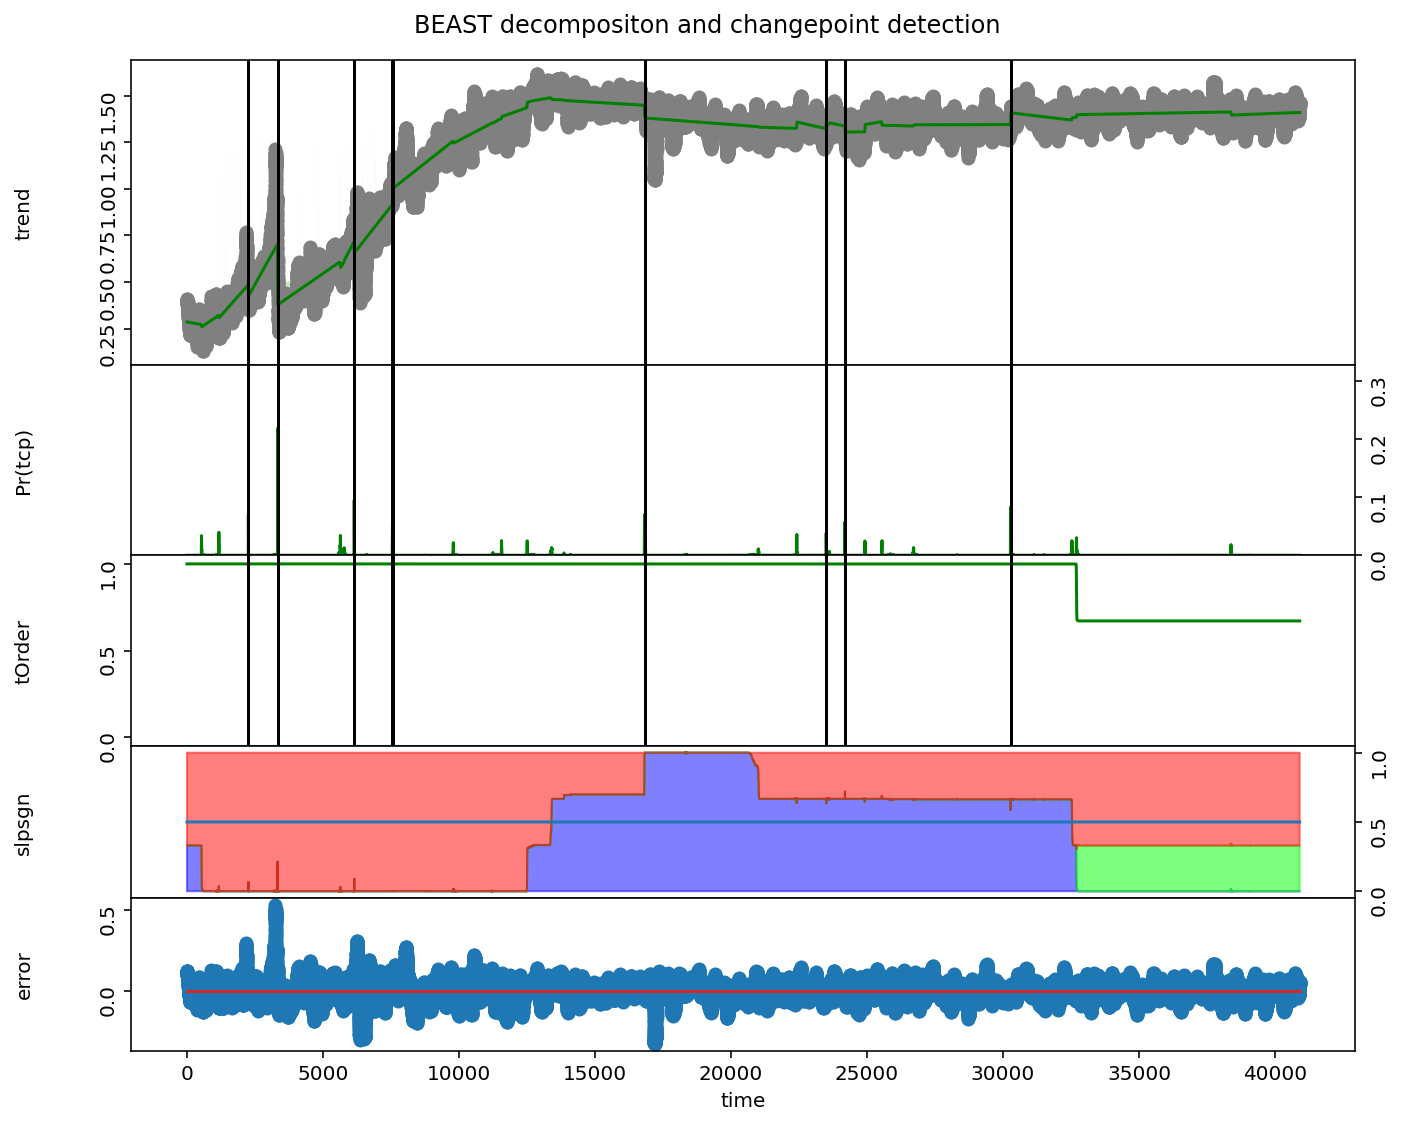

In [96]:
o = rb.beast(df.PPARG.rolling(100).mean().dropna(), season='none', quiet=True)
rb.plot(o)

In [87]:
df = sc.get.obs_df(myeloid_tfs, keys=['cell_type', 'dpt_pseudotime', 'PPARG'])

In [88]:
df = df.loc[df.cell_type.isin(['Monocytes', 'MoAM-1', 'MoAM-3 mature', 'MoAM-4 profibrotic'])]

In [89]:
df = df.sort_values(['cell_type', 'dpt_pseudotime'])

/Progress:100.0% done[==============================================================]


(<Figure size 720x576 with 5 Axes>,
 array([<AxesSubplot:xlabel='[]', ylabel='trend'>,
        <AxesSubplot:xlabel='[]', ylabel='Pr(tcp)'>,
        <AxesSubplot:xlabel='[]', ylabel='tOrder'>,
        <AxesSubplot:xlabel='[]', ylabel='slpsgn'>,
        <AxesSubplot:xlabel='time', ylabel='error'>], dtype=object))

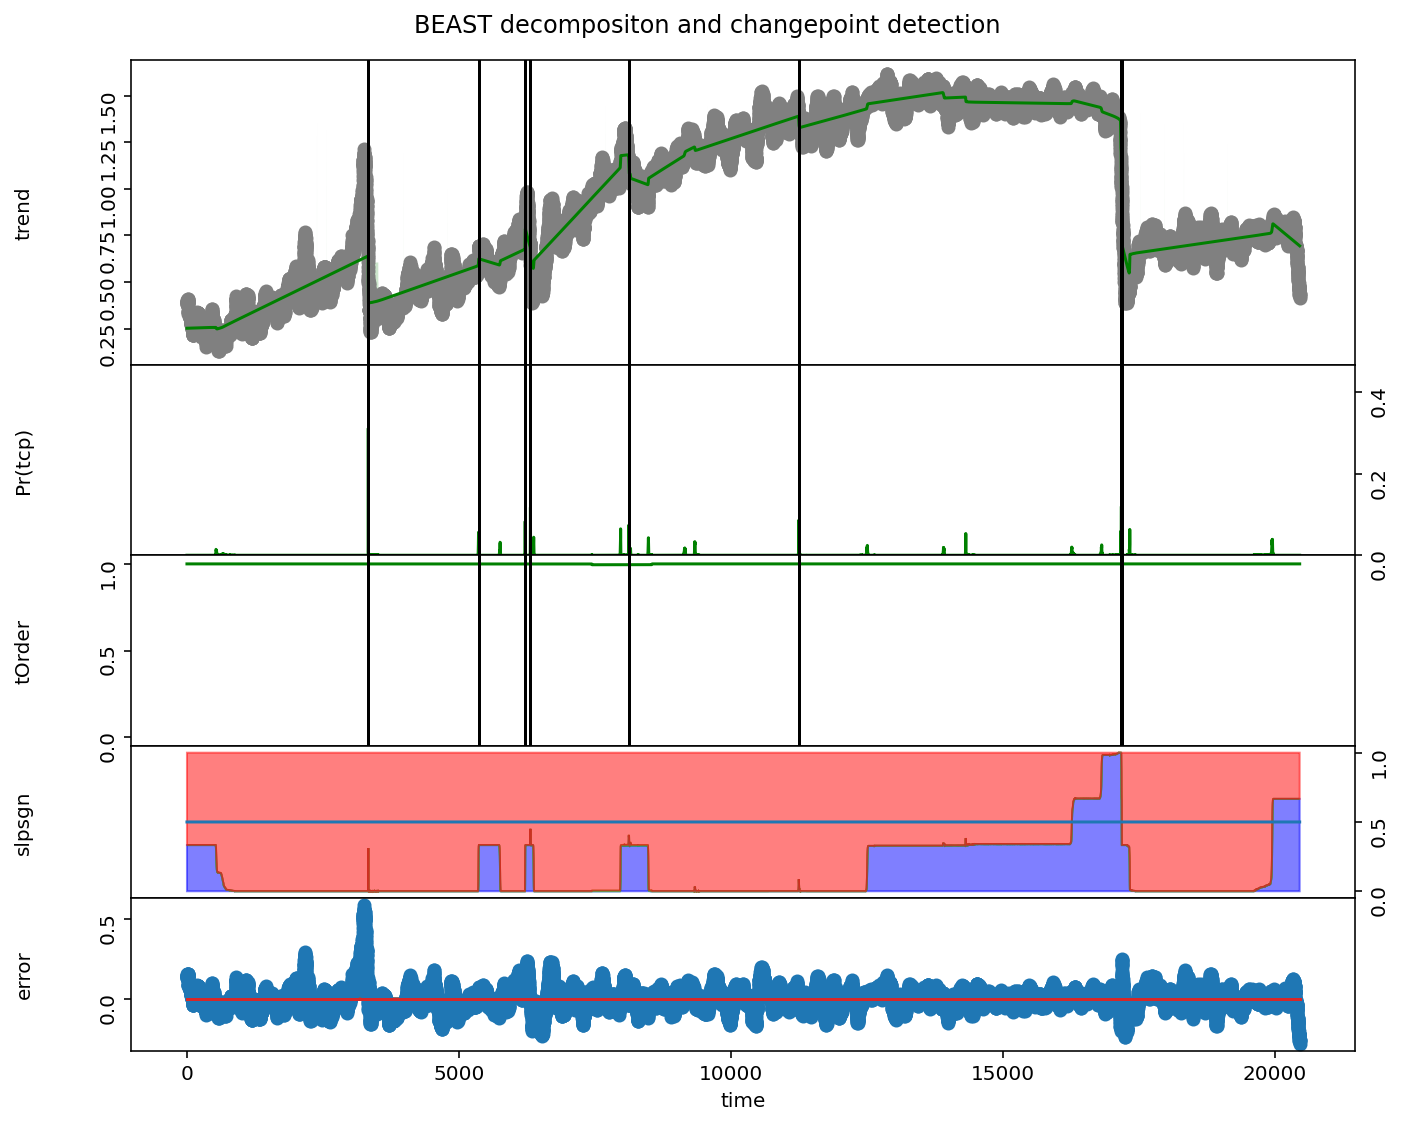

In [91]:
o = rb.beast(df.PPARG.rolling(100).mean().dropna(), season='none', quiet=True)
rb.plot(o)

### Trajectory 2: Monocytes → MoAM-1 (?) → MoAM-4 profibrotic

/projects/b1038/Pulmonary/nmarkov/ssc-v2/code/venv/lib/python3.9/site-packages/scanpy/plotting/_tools/paga.py:1188: UserWarning: FixedFormatter should only be used together with FixedLocator
  groups_axis.set_yticklabels(['', xlabel, ''], fontsize=ytick_fontsize)
/projects/b1038/Pulmonary/nmarkov/ssc-v2/code/venv/lib/python3.9/site-packages/scanpy/plotting/_tools/paga.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  anno_axis.set_yticklabels(['', anno, ''], fontsize=ytick_fontsize)


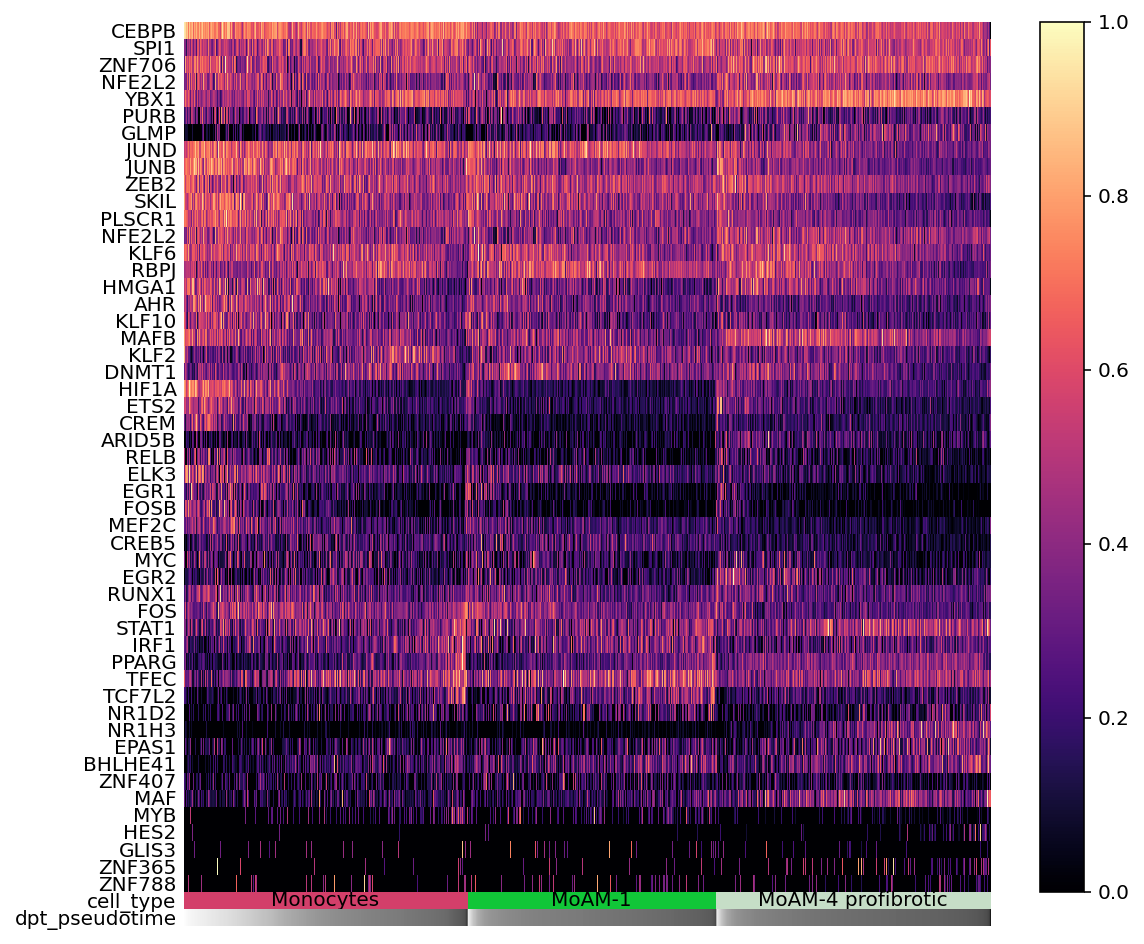

In [ ]:
ax = sc.pl.paga_path(
    myeloid_tfs,
    nodes=['Monocytes', 'MoAM-1', 'MoAM-4 profibrotic'],
    keys=ORDER,
    use_raw=False,
    n_avg=10,
    normalize_to_zero_one=True,
    show=False,
    color_map='magma'
)
ax.images[0].set_rasterized(True)
ax.figure.savefig('10b_plots/03_tf_trajectory2.pdf', dpi=300)

Option 2 without MoAM-1

/projects/b1038/Pulmonary/nmarkov/ssc-v2/code/venv/lib/python3.9/site-packages/scanpy/plotting/_tools/paga.py:1188: UserWarning: FixedFormatter should only be used together with FixedLocator
  groups_axis.set_yticklabels(['', xlabel, ''], fontsize=ytick_fontsize)
/projects/b1038/Pulmonary/nmarkov/ssc-v2/code/venv/lib/python3.9/site-packages/scanpy/plotting/_tools/paga.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  anno_axis.set_yticklabels(['', anno, ''], fontsize=ytick_fontsize)


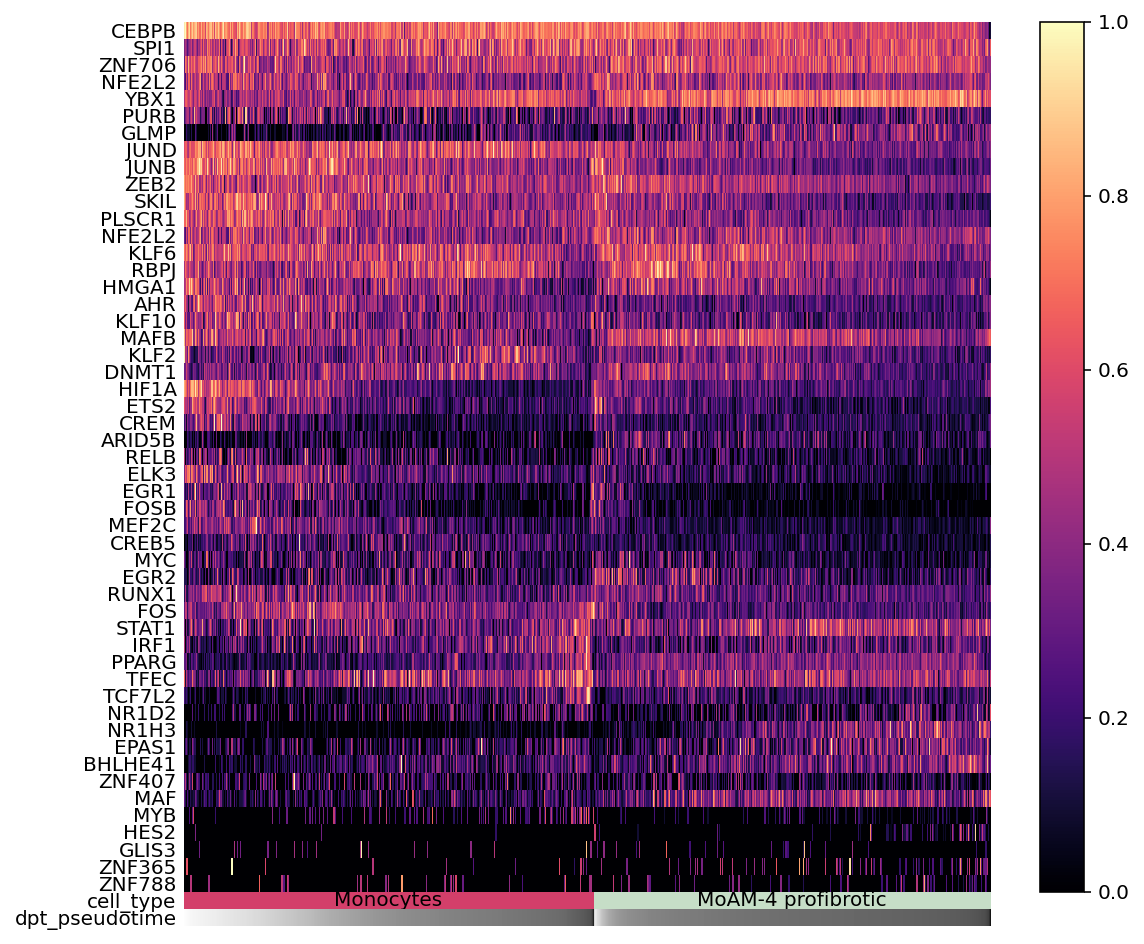

In [ ]:
ax = sc.pl.paga_path(
    myeloid_tfs,
    nodes=['Monocytes', 'MoAM-4 profibrotic'],
    keys=ORDER,
    use_raw=False,
    n_avg=10,
    normalize_to_zero_one=True,
    show=False,
    color_map='magma'
)
ax.images[0].set_rasterized(True)
ax.figure.savefig('10b_plots/03_tf_trajectory2-var2.pdf', dpi=300)

### Broken trajectory: Monocytes → MoAM-1 → MoAM-3 mature → MoAM-4 profibrotic

/projects/b1038/Pulmonary/nmarkov/ssc-v2/code/venv/lib/python3.9/site-packages/scanpy/plotting/_tools/paga.py:1188: UserWarning: FixedFormatter should only be used together with FixedLocator
  groups_axis.set_yticklabels(['', xlabel, ''], fontsize=ytick_fontsize)
/projects/b1038/Pulmonary/nmarkov/ssc-v2/code/venv/lib/python3.9/site-packages/scanpy/plotting/_tools/paga.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  anno_axis.set_yticklabels(['', anno, ''], fontsize=ytick_fontsize)


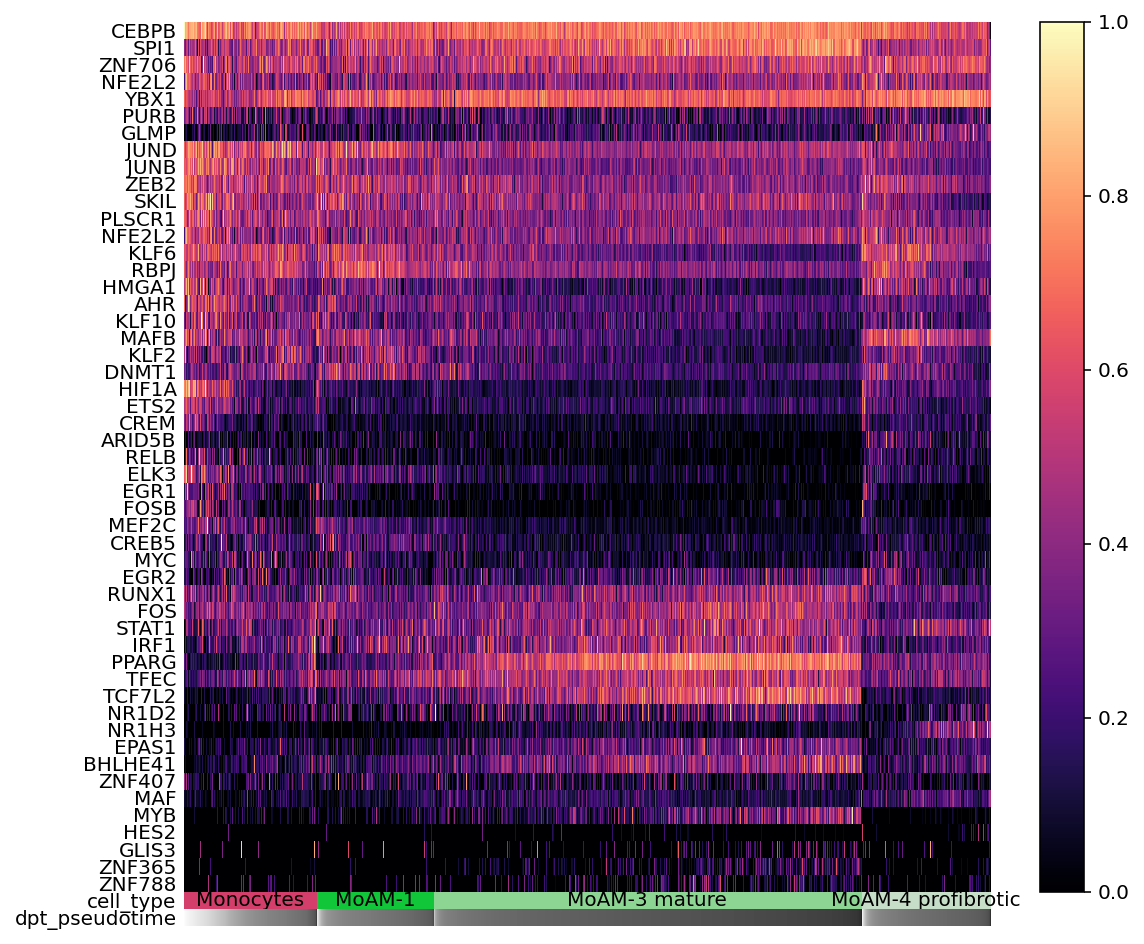

In [ ]:
ax = sc.pl.paga_path(
    myeloid_tfs,
    nodes=['Monocytes', 'MoAM-1', 'MoAM-3 mature', 'MoAM-4 profibrotic'],
    keys=ORDER,
    use_raw=False,
    n_avg=10,
    normalize_to_zero_one=True,
    show=False,
    color_map='magma'
)
ax.images[0].set_rasterized(True)
ax.figure.savefig('10b_plots/03_tf_broken_trajectory.pdf', dpi=300)

**NB**: part of Monocytes are really distinct from other cells and have high diffusion pseudotime, we should possibly investigate that

Based on a few TFs the last heatmap appears to be broken: MAFB, KLF2, KLF6, PPARG, SPI1, HMGA1, TCF7L2, BHLHE41, EPAS1.

For them the origin of MoAM-4 profibrotic seems to be in the MoAM-1 or in Monocytes